**Восстановление смеси плотностей распределений.**

алгоритм EM (базовый) с фиксированным количеством компонент смеси

Евгений Борисов borisov.e@solarl.ru

---

## библиотеки

In [1]:
from time import time

import numpy as np
import matplotlib.pyplot as plt

# from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import train_test_split

##  загружаем данные 

In [2]:
X = np.loadtxt('../data/400_1/points_9.txt')
n_comp = 4 # количество компонент

In [3]:
# X = np.vstack([ 
#            np.random.normal(loc=-2.0, scale=1.0, size=[200,2]),
#            np.random.normal(loc=2.0, scale=1.0, size=[200,2]),
#        ])
# 
# n_comp = 2 # количество компонент

### рисуем данные


In [4]:
plot_frame = np.vstack([ X.min(axis=0)-0.5,X.max(axis=0)+0.5 ])
plot_frame

array([[ 1.64584936,  0.4766026 ],
       [10.09105573,  7.32364133]])

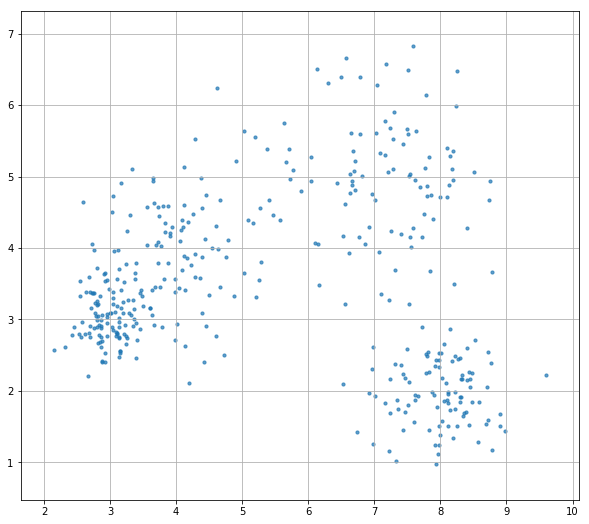

In [5]:
plt.gcf().set_size_inches(10,9)
plt.xlim(plot_frame[:,0])
plt.ylim(plot_frame[:,1])

plt.scatter( X[:,0], X[:,1],s=10,alpha=0.7)
plt.grid()
plt.show()

## инициализация параметров

In [6]:
def get_seed(): t = time() ; return int(((t%1)/(t//1))*1e11)

In [7]:
# инициализация генератора псевдослучайных чисел
np.random.seed( seed=get_seed() )

In [8]:
# матрицы ковариаций признаков для каждой компоненты смеси
S = np.cov(X.T)
S = [ S for i in range(n_comp) ]

# начальные веса компонент (априорная вероятность)
w = np.ones(n_comp) / n_comp 


# мат.ожидания для компонент смеси
mu = np.mean(X,axis=0) 
mu = [mu]+[ np.random.normal(loc=mu, scale=2.0, size=mu.shape) for i in range(1,n_comp) ]

# x_max = np.max(X,axis=0)
# mu = [ np.mean(X,axis=0) ] + [ np.random.rand(X.shape[1])*x_max  for i in range(1,n_comp) ]

In [9]:
def plot_mix( S, mu, b=2.0):
    # рисуем мат.ожидание
    mu_ = np.vstack(mu)
    plt.scatter( mu_[:,0], mu_[:,1],s=30,alpha=0.7)

    # рисуем проекцию гауссианы
    a = np.linspace(0.0,2.0,20)*np.pi 
    c = np.array([ np.cos(a), np.sin(a) ])
    
    for j in range(len(S)):
        s = 1.0/( 2.0*np.pi*np.sqrt( np.linalg.det(S[j]) ) ) * b
        #  собственные значения и векторы матрицы ковариаций для компоненты смеси j
        v, l = np.linalg.eig(S[j])  
        v = v*l.sum(axis=1)
        el = c * v.reshape(2,1) * s + mu[j].reshape(2,1)
        plt.plot( el[0,:] , el[1,:]  ) 

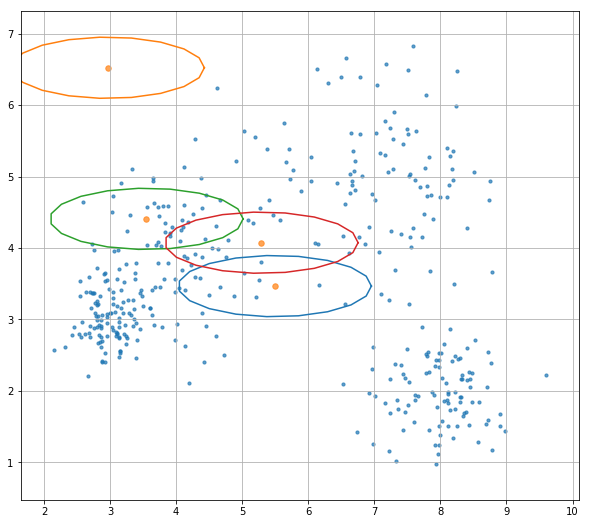

In [10]:
# рисуем начальное состояние
plt.gcf().set_size_inches(10,9)
plt.xlim(plot_frame[:,0])
plt.ylim(plot_frame[:,1])

plt.scatter( X[:,0], X[:,1],s=10,alpha=0.7)
plot_mix(S,mu,b=5.0)
plt.grid()
plt.show()

## оптимизация параметров

фунция n-мерной нормальной плотности распределения
$$
\varphi(x;\theta)
=\mathcal{N}(x;\Sigma,\mu)
=\frac{ \exp\left( -\frac{1}{2}(x-\mu)^T \cdot \Sigma^{-1} \cdot (x-\mu) \right)  }
      { \sqrt{ (2\pi)^n \det \Sigma } }
$$

In [11]:
# фунция n-мерной нормальной плотности распределения
def dens_gauss(X,iS,dS,mu):
    n = X.shape[1] # размерность пространства
    s = 1.0 / np.sqrt( dS * np.square(2.0*np.pi)  )
    xm = X - mu
    return s*np.exp( -0.5 * (xm.dot(iS)*xm).sum(axis=1) )
    

оценка параметров

$$
g_{ij} = \frac{ w_j \cdot \mathcal{N}(x_i;\Sigma_j,\mu_j) }
              { \sum\limits_k w_k \cdot \mathcal{N}(x_i;\Sigma_k,\mu_k) }
$$



In [12]:
# оценка параметров
def e_step( X, S, mu, w ):
    n_comp = len(w)
    m = X.shape[0] # количество учебных примеров
   
    # для для каждой компоненты смеси вычисляем ...
    # обратные матрицы ковариаций признаков 
    iS = [ np.linalg.inv(si)  for si in S ] 
    # определители матрицы ковариаций признаков 
    dS = [ np.linalg.det(si)  for si in S ] 
    
    # взвешеное значение плотности распределения для каждой точки по всем компоненитам смеси
    p = np.vstack([ dens_gauss(X,iS[j],dS[j],mu[j]) * w[j] for j in range(n_comp)] )
    
    return p/p.sum(axis=0)


изменение параметров

$$
w_j = \frac{1}{m}\sum\limits_{i=1}^{m} g_{ij}\ \ ;\ \ 
\mu_j = \frac{ \sum\limits_{i=1}^{m} g_{ij} \cdot x_i }{ \sum\limits_{i=1}^{m} g_{ij} }
$$

$$
\Sigma_j = \frac{ \left( (X-\mu_j)\cdot g \right)^T \left( (X-\mu_j)\cdot g \right)  }
                { G\cdot\sum\limits_{i=1}^{m} g_{ij} } ;  0 < G \leq 1
$$



In [18]:
# оптимизация параметров
def m_step(X,g,G_FACTOR=1.0):
    n_comp = g.shape[0]
    
    sg = g.sum(axis=1)
    
    w = sg/X.shape[0]   # веса компонент смеси
    
    # мат.ожидания для компонент смеси
    mu = [ ( g[j,:].reshape(X.shape[0],1) * X ).sum(axis=0) / sg[j] for j in range(n_comp) ]

    # изменяем матрицы ковариаций 
    xm = [ ( X-mu[j] ) * g[j].reshape(X.shape[0],1) for j in range(n_comp) ]
    S = [ xm[j].T.dot(xm[j]) / ( sg[j]*G_FACTOR ) for j in range(n_comp)  ]   
    
    return S, mu, w
    

In [14]:
# EM базовый 
MAX_ITER = 100 # максимальное количество циклов
G_MAX = 1e-3 # минимальное изменение оценки (критерий остановки EM)

# начальные значения оценок
g = np.zeros( [ n_comp, X.shape[0],  ]  ) 

for i in range(MAX_ITER):
    g0 = g # сохраняем старую оценку параметров
    g = e_step(X,S,mu,w) # оценка параметров
    S, mu, w = m_step(X,g) # оптимизация параметров

    # считаем изменение оценки
    gm = np.abs( g - g0 ).max() 

    assert ~np.isnan(gm), 'ошибка вычислений, неудачные начальные параметры'

    print("%i: %f/%f"%(i,gm,G_MAX))

    #  проверяем условия завершения работы
    if( gm < G_MAX ): break # изменение оценки ниже порога, конец работы



0: 0.721977/0.001000
1: 0.703492/0.001000
2: 0.900794/0.001000
3: 0.454352/0.001000
4: 0.647758/0.001000
5: 0.250882/0.001000
6: 0.296590/0.001000
7: 0.386641/0.001000
8: 0.484896/0.001000
9: 0.713288/0.001000
10: 0.662580/0.001000
11: 0.338554/0.001000
12: 0.236212/0.001000
13: 0.280306/0.001000
14: 0.361106/0.001000
15: 0.233245/0.001000
16: 0.306925/0.001000
17: 0.301660/0.001000
18: 0.460534/0.001000
19: 0.553995/0.001000
20: 0.438648/0.001000
21: 0.381862/0.001000
22: 0.385935/0.001000
23: 0.343792/0.001000
24: 0.282584/0.001000
25: 0.293065/0.001000
26: 0.284565/0.001000
27: 0.366751/0.001000
28: 0.278752/0.001000
29: 0.193230/0.001000
30: 0.111424/0.001000
31: 0.073097/0.001000
32: 0.048859/0.001000
33: 0.033775/0.001000
34: 0.030414/0.001000
35: 0.028138/0.001000
36: 0.025993/0.001000
37: 0.024004/0.001000
38: 0.022163/0.001000
39: 0.020451/0.001000
40: 0.019281/0.001000
41: 0.018356/0.001000
42: 0.017392/0.001000
43: 0.016394/0.001000
44: 0.015370/0.001000
45: 0.014331/0.00100

## рисуем результат

In [16]:
# для для каждой компоненты смеси вычисляем ...

# обратные матрицы ковариаций признаков 
iS = [ np.linalg.inv(si)  for si in S ] 
# определители матрицы ковариаций признаков 
dS = [ np.linalg.det(si)  for si in S ] 
# значение плотности для каждой точки набора
p = np.vstack([ dens_gauss(X,iS[i],dS[i],mu[i]) for i in range(len(w)) ])

# номера компонент с максимальным значением плотности для каждой точки набора
pc = np.argmax(p,axis=0)

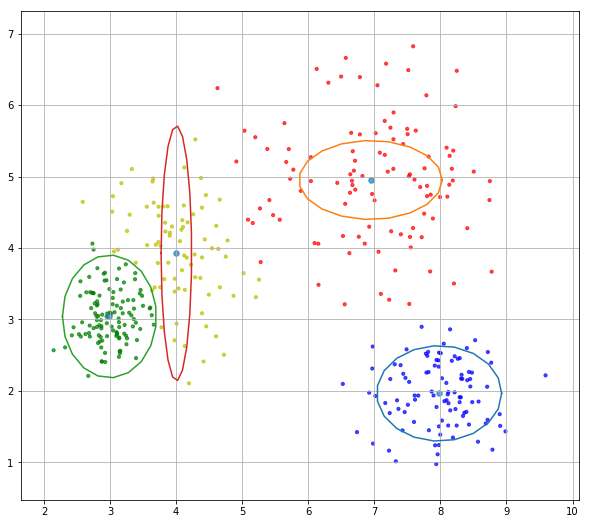

In [17]:
plt.gcf().set_size_inches(10,9)
plt.xlim(plot_frame[:,0])
plt.ylim(plot_frame[:,1])
c = [ ['b','r','g','y'][j] for j in pc  ]
plt.scatter( X[:,0], X[:,1],s=10,alpha=0.7,c=c)
plot_mix(S,mu,b=5.0)
plt.grid()
plt.show()